# Attention-based Medical Caption Generation 

# 1.Business Problem :

* Chest radiography is the most common imaging examination globally, critical for screening, diagnosis, and management of many life threatening diseases. Automated chest radiograph interpretation at the level of practicing radiologists could provide substantial benefit in many medical settings, from improved workflow prioritization and clinical decision support to large-scale screening and global population health initiatives.

* Open-i has collection of chest X-Ray Images from Indiana University hospital network. Data contains two files, one for Images and other one for xml report of radiography. For each report, there could be multiple images. Image has mainly two views Frontal and Lateral view. XML report contains findings, indication, comparisons and Impression. There are 3955 reports and 7470 images in total.


## 1.2 Problem Statement :


Our task at hand is to generate impression given an image of radiography.

<h2> 1.3 Sources/Useful Links</h2>

http://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9
http://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d  
https://www.kaggle.com/raddar/chest-xrays-indiana-university

<h1>2. Deep Learning Probelm </h1>

<h2> 2.1 Data </h2>

* There are two set of files, one contains image of patients and the other contains Report of that particular patient.
* Report is in XML format
* Report contains image_id , caption of an image, indication of patient, findings and impression

<h2> 2.2 Performance Metric </h2>

The BLEU score is a string-matching algorithm that provides basic quality metrics for MT researchers and developers.

The BLEU metric scores a translation on a scale of 0 to 1, in an attempt to measure the adequacy and fluency of the MT output. The closer to 1 the test sentences score, the more overlap there is with their human reference translations and thus, the better the system is deemed to be. BLEU scores are often stated on a scale of 1 to 100 to simplify communication, but this should not be confused with the percentage of accuracy.


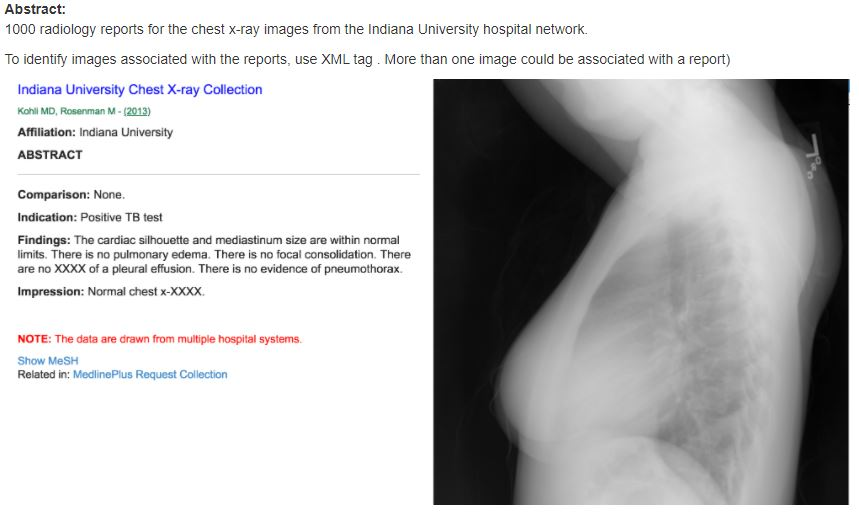

In [95]:
from IPython.display import Image
Image('/content/drive/My Drive/Colab Notebooks/sample.JPG')

In [ ]:
#!unzip '/content/drive/My Drive/Colab Notebooks/ecgen-radiology.zip' -d '/content/drive/My Drive/Colab Notebooks'

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/NLMCXR_png.zip' -d '/content'

# Importing Libraries :

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re
import seaborn as sns
#from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
columns = ["image_id", "caption", "comparison", "indication", "findings", "impression","height","width"]
df = pd.DataFrame(columns = columns)

In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

# Convert XML to DATAFRAME

In [53]:
#https://www.youtube.com/watch?v=r6dyk68gymk
#https://www.geeksforgeeks.org/xml-parsing-python/
#https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size
for file in tqdm(os.listdir("ecgen-radiology/")):
    #find files ends with .xml only
    if file.endswith(".xml"):
      k = "ecgen-radiology/"
      path = k + file
      mytree = ET.parse(path)# parsing xml report
      comparision = mytree.find(".//AbstractText[@Label='COMPARISON']").text # extracting comaparison text
      indication = mytree.find(".//AbstractText[@Label='INDICATION']").text #extracting indication text
      findings = mytree.find(".//AbstractText[@Label='FINDINGS']").text # extracting findings text
      impression = mytree.find(".//AbstractText[@Label='IMPRESSION']").text  # extracting impression text

      mytree = ET.parse(path)
      for x in mytree.findall("parentImage"):
          image_id = x.attrib['id']+".png"
            #print(image_id)
          filename = '/content/NLMCXR_png/' + image_id
          image = cv2.imread(filename) # reading image
             
          height, width, channels = image.shape
          caption = '' if x.find('caption').text is None else x.find('caption').text
     
          df = df.append(pd.Series([image_id, caption, comparision, indication, findings, impression,height,width],
                                                         index = columns), ignore_index = True)



100%|██████████| 3955/3955 [01:26<00:00, 45.92it/s]


In [54]:
df.head()

,image_id,caption,comparison,indication,findings,impression,height,width
0,CXR594_IM-2187-1001.png,XR Chest PA and Lateral,None available.,"Pain, weakness",There are T-spine osteophytes. There calcified...,1. Borderline cardiomegaly. 2. Age-indetermina...,419,512
1,CXR594_IM-2187-2001.png,XR Chest PA and Lateral,None available.,"Pain, weakness",There are T-spine osteophytes. There calcified...,1. Borderline cardiomegaly. 2. Age-indetermina...,635,512
2,CXR532_IM-2140-1001.png,"PA and lateral chest x-XXXX dated XXXX, XXXX a...",None.,"XXXX-year-old woman, XXXX vehicle collision.","The lungs are clear bilaterally. Specifically,...",No acute cardiopulmonary abnormality.,420,512
3,CXR532_IM-2140-2001.png,"PA and lateral chest x-XXXX dated XXXX, XXXX a...",None.,"XXXX-year-old woman, XXXX vehicle collision.","The lungs are clear bilaterally. Specifically,...",No acute cardiopulmonary abnormality.,624,512
4,CXR526_IM-2137-1002.png,"XXXX and lateral chest XXXX, XXXX at time XXXX",None,preop for left hip revision XXXX.,None,Minimal cardiomegaly. Lungs are clear. Fat see...,509,512


In [66]:
df.describe()

,image_id,caption,comparison,indication,findings,impression,height,width
count,7470,7470,6313,7311,6473,7418,7470,7470
unique,7470,697,394,2454,2553,1770,304,1
top,CXR12_IM-0133-1001.png,Xray Chest PA and Lateral,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.,624,512
freq,1,2363,1592,253,98,586,1983,7470


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7470 entries, 0 to 7469
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    7470 non-null   object
 1   caption     7467 non-null   object
 2   comparison  5932 non-null   object
 3   indication  7035 non-null   object
 4   findings    7470 non-null   object
 5   impression  7470 non-null   object
 6   height      7470 non-null   int64 
 7   width       7470 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 525.2+ KB


In [68]:
df.to_csv("/content/drive/My Drive/Colab Notebooks/df1.csv", index=False)

In [100]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df1.csv')

In [102]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing_Percentage'])
missing__train_data.head(6)

,Total,Missing_Percentage
comparison,1157,15.488621
findings,997,13.346720
indication,159,2.128514
impression,52,0.696118
caption,2,0.026774
width,0,0.000000


# Handling Missing values :

In [103]:
df['caption'] = df['caption'].fillna('no caption')# filling nan with no caption
df['comparison'] = df['comparison'].fillna('no comparison') # filling nan with no comparison
df['findings'] = df['findings'].fillna('no findings') # filliing nan with no findings 
df['indication'] = df['indication'].fillna('no indication') # filling nan with no indication
df['impression'] = df['impression'].fillna('no impression') # filling nan with no impression

In [104]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing_Percentage'])
missing__train_data.head(6)

,Total,Missing_Percentage
width,0,0.0
height,0,0.0
impression,0,0.0
findings,0,0.0
indication,0,0.0
comparison,0,0.0


In [6]:
#remove HTML from the Text column and save in the Text column only
def preprocessing(df):
    column = []
    for txt in tqdm(df.values):
        txt = txt.lower()
        txt = re.sub(r"x-xxxx","",txt)
        txt = re.sub(r"xxxx","",txt)
        txt = re.sub(r"year-old", "", txt)
        txt = re.sub(r"2 images","",txt)
        txt = re.sub('[^A-Za-z]+', ' ', txt)
        column.append(txt.strip())
    return column

In [7]:
df.columns[1:-2]

Index(['caption', 'comparison', 'indication', 'findings', 'impression'], dtype='object')

In [8]:
for i in df.columns[1:-2] :
  df[i] = preprocessing(df[i])

100%|██████████| 7470/7470 [00:00<00:00, 132174.00it/s]


In [9]:
df

,image_id,caption,comparison,indication,findings,impression,height,width
0,CXR594_IM-2187-1001.png,xr chest pa and lateral,none available,pain weakness,there are t spine osteophytes there calcified ...,borderline cardiomegaly age indeterminate chro...,419,512
1,CXR594_IM-2187-2001.png,xr chest pa and lateral,none available,pain weakness,there are t spine osteophytes there calcified ...,borderline cardiomegaly age indeterminate chro...,635,512
2,CXR532_IM-2140-1001.png,pa and lateral chest dated at a m,none,woman vehicle collision,the lungs are clear bilaterally specifically n...,no acute cardiopulmonary abnormality,420,512
3,CXR532_IM-2140-2001.png,pa and lateral chest dated at a m,none,woman vehicle collision,the lungs are clear bilaterally specifically n...,no acute cardiopulmonary abnormality,624,512
4,CXR526_IM-2137-1002.png,and lateral chest at time,none,preop for left hip revision,no findings,minimal cardiomegaly lungs are clear fat seen ...,509,512
...,...,...,...,...,...,...,...,...
7465,CXR1280_IM-0187-1001.png,views of the chest,,preop,the cardiac silhouette and mediastinum size ar...,no acute abnormality,512,512
7466,CXR1280_IM-0187-3001.png,views of the chest,,preop,the cardiac silhouette and mediastinum size ar...,no acute abnormality,511,512
7467,CXR119_IM-0128-1001.png,xray chest pa and lateral,,right arm numbness right sided chest pain for ...,frontal and lateral views of the chest show no...,no acute or active cardiac pulmonary or pleura...,512,512
7468,CXR1253_IM-0171-0001-0001.png,xray chest pa and lateral,no comparison,,heart size and pulmonary vascularity appear wi...,no evidence of active disease,618,512


In [10]:
df.shape

(7470, 8)

In [11]:
df.replace("", float("NaN"), inplace=True)
#df.dropna(subset = ["image_id"], inplace=True)
df.shape

(7470, 8)

# Exploring Image data :

In [12]:
print("Number of images in total :",len(df['image_id']))

Number of images in total : 7470


In [13]:
image_grp = []
for i in range(df.shape[0]):
  image_grp.append('_'.join(df['image_id'][i].split('-')[0:-1]))
df['image_grp'] = image_grp

In [14]:
image_per_patient = df.groupby('image_grp')['image_id'].nunique()

In [15]:
image_per_patient.value_counts()

2    3227
1     457
3     173
4      10
Name: image_id, dtype: int64

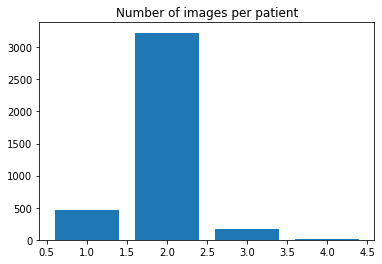

In [16]:
plt.bar(image_per_patient.value_counts().index, height=image_per_patient.value_counts().values)
plt.title("Number of images per patient")
plt.show()

No handles with labels found to put in legend.


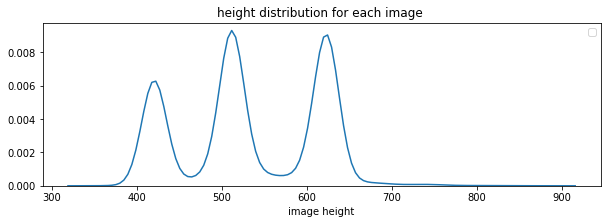

In [96]:
plt.figure(figsize=(10,3))
sns.distplot(df['height'], hist=False)
plt.title('height distribution for each image ')
plt.xlabel('image height')
plt.legend()
plt.show()

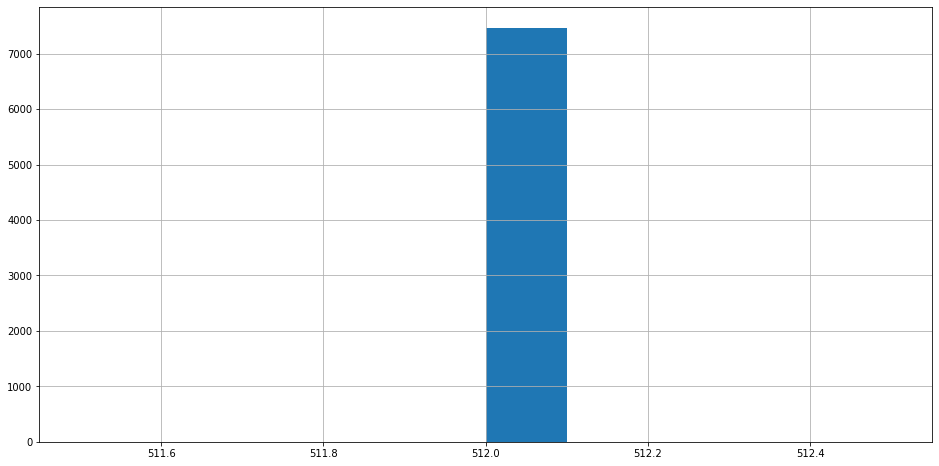

In [18]:
df['width'].hist(figsize=(16, 8))

# Impression data :

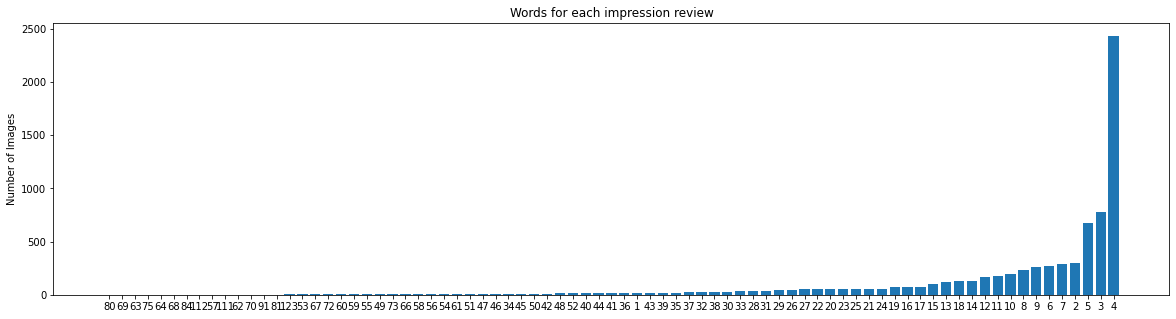

In [19]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
countword = df['impression'].str.split().apply(len).value_counts()
dict_word = dict(countword)
dict_word = dict(sorted(dict_word.items(), key=lambda kv: kv[1]))


ind = np.arange(len(dict_word))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(dict_word.values()))

plt.ylabel('Number of Images')
plt.title('Words for each impression review')
plt.xticks(ind, list(dict_word.keys()))
plt.show()


In [20]:
approved_word_count = df['impression'].str.split().apply(len)
approved_word_count = approved_word_count.values



No handles with labels found to put in legend.


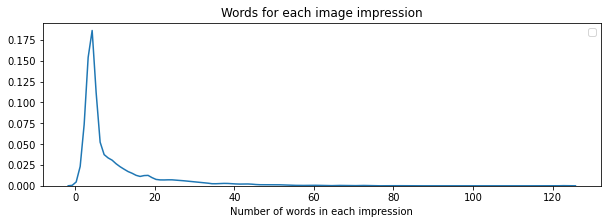

In [21]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False)
plt.title('Words for each image impression')
plt.xlabel('Number of words in each impression')
plt.legend()
plt.show()

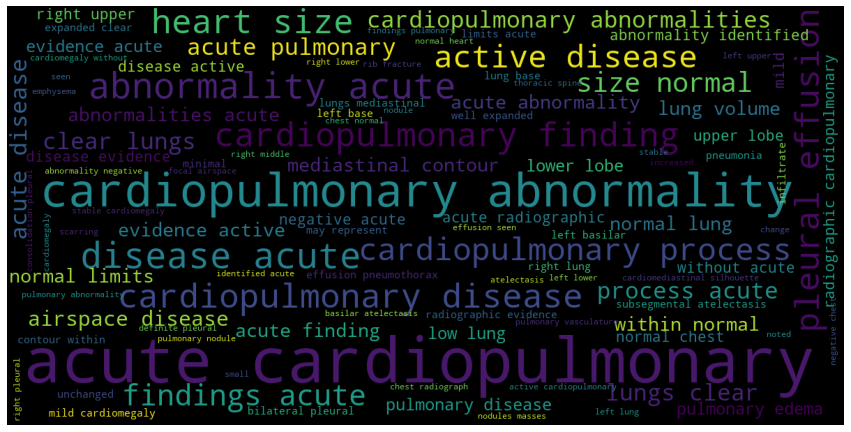

In [22]:
#https://www.kaggle.com/duttadebadri/detailed-nlp-project-prediction-visualization
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        #stopwords=stopwords,
        max_words=700,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(' '.join(data.astype(str)))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['impression'])

# Findings :

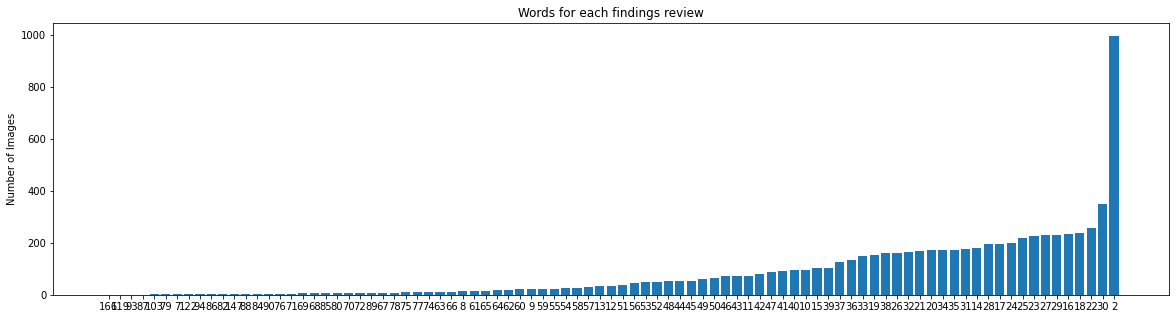

In [23]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
countword = df['findings'].str.split().apply(len).value_counts()
dict_word = dict(countword)
dict_word = dict(sorted(dict_word.items(), key=lambda kv: kv[1]))


ind = np.arange(len(dict_word))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(dict_word.values()))

plt.ylabel('Number of Images')
plt.title('Words for each findings review')
plt.xticks(ind, list(dict_word.keys()))
plt.show()


No handles with labels found to put in legend.


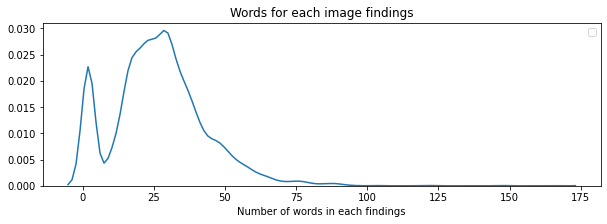

In [24]:
approved_word_count = df['findings'].str.split().apply(len)
approved_word_count = approved_word_count.values

plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False)
plt.title('Words for each image findings')
plt.xlabel('Number of words in each findings')
plt.legend()
plt.show()

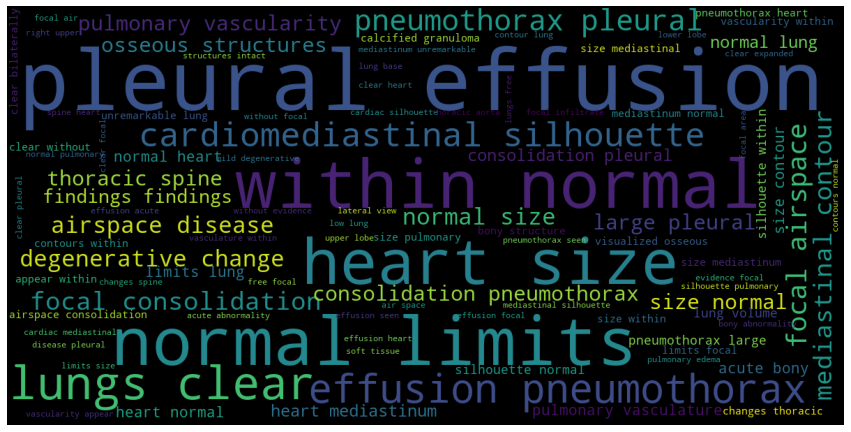

In [23]:
show_wordcloud(df['findings'])

# Indication data :

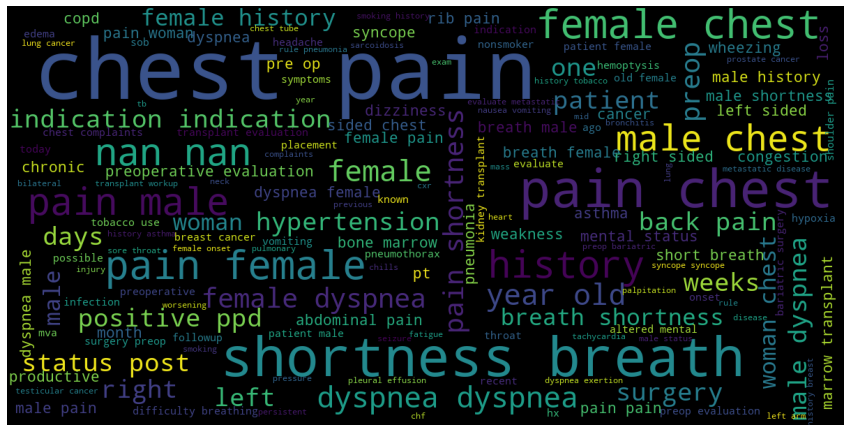

In [24]:
show_wordcloud(df['indication'])

# Displaying Report with Image

In [28]:
image_per = df.groupby('image_grp')['image_id']

In [44]:
for key,item in image_per :
  print(item.values)
  image_list = item.values
  break;

['CXR1000_IM-0003-1001.png' 'CXR1000_IM-0003-2001.png'
 'CXR1000_IM-0003-3001.png']


# Displaying Report of an patient :

Caption :  pa and lateral chest


Indication :  male


Findings :  there is increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation the cardiac silhouette is within normal limits opacity in the left midlung overlying the posterior left th rib may represent focal airspace disease no pleural effusion or pneumothorax no acute bone abnormality


IMPRESSION :  increased opacity in the right upper lobe with associated atelectasis may represent focal consolidation or mass lesion with atelectasis recommend chest ct for further evaluation opacity overlying the left th rib may represent focal airspace disease


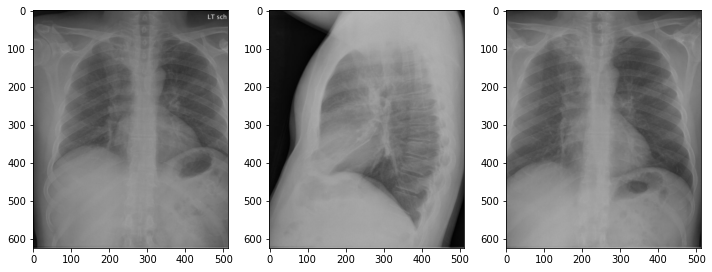

In [99]:

fig, axs = plt.subplots(1, len(image_list), figsize = (10,10), tight_layout=True)
i = 0
for img, subplot in zip(image_list, axs.flatten()):
    filename = '/content/NLMCXR_png/' + img
    image = cv2.imread(filename)
    imgplot = axs[i].imshow(image)
    i += 1
d1 = df[df['image_id']==image_list[0]]

print("Caption : ",d1['caption'].values[0])
print("\n\nIndication : ",d1['indication'].values[0])
print("\n\nFindings : ",d1['findings'].values[0])
print("\n\nIMPRESSION : ",d1['impression'].values[0])


# Summary :

1. Extracting information from XML format to dataframe for further analysis 
2. Number of images per patient 
    * 3227 patients has two images of chest x-ray
    * 457 patients has one image of chest x-ray
    * 173 patients has three images of chest x-ray
    * 10 patients has four images of chest x-ray
3. Height of images are different but width of all images are same.
4. About 2500 images with impressions are of length four.
5. Most frequenctly occuring word in impression is acute cardiopulmanory.
6. Only three columns contain vital information of patient,findings, indication and impression. Caption contains type of view either later/frontal/PosteriorAnterior view.
7. About 1000 images with findings of length two and frequently occuring word is pleural effusion.
8. Filling missing values of impression as no impression.